<a href="https://colab.research.google.com/github/Carrambert/T-xis-amarelos/blob/main/Trabalho_BD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução
Integrantes do grupo: Carrambert Albuquerque, Igor Deo Alves, João Victor de Carvalho Mansur, Logan Miranda, Roger Castellar



Esse é o trabalho final da disciplina de Banco de Dados não convencionais. Nessa entrega, nós devemos realizar uma análise em cima dos dados das corridas de táxis amarelos da cidade de Nova Iorque no ano de 2022.
<br>
Nós temos a opção de escolher uma dentre dois conjuntos de análises:
<br>
1. Quais os top-5 destinos (regiões) por taxistas por mês durante o
ano de 2022? Acumule todos os top-5 destinos e mostre a
distribuição (número de taxistas) que os frequentaram em cada
mês do ano de 2022. Mostre a quantidade de corridas para os
top-5 destinos e suas adjacências imediatas (regiões que fazem
fronteira) por mês para o ano de 2022.
2. Qual o ganho médio por milha por mês por cada taxista durante
todo o ano de 2022? Qual a taxa de corrida canceladas por mês
para os taxistas que possuem o ganho médio por milha superior a
média geral para o ano de 2022? Qual o ganho médio para os
top-10 taxistas que mais rodaram por mês durante o ano de
2022? Suponha que incida uma taxa de 2% sobre cartão de
crédito. Refaça as três análises anteriores.
<br>

### Nós optamos pela análise 2
O desenvolvimento da solução para análise será descrita completamente nesse notebook. Sendo efetuada em alguns passos:
1. Extração
2. Limpeza dos dados
3. Consulta

**OBS**: Professor, note que pode existir algumas partes do código que estão cortadas no relatório, por conta da célula ser muito extensa, e isso vem padrão da exportação do notebook como PDF. Esses cortes não prejudicam o entendimento das consultas realizadas, porém se ainda desejar visualizar os códigos na sua totalidade, eles estão em perfeito estado no arquivo .py ou .ipynb, que também foram encaminhados ao senhor.

## 1: Extração
O dataset está disponibilizado no [site](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) da comissão de táxis e limousines de Nova Iorque. Os arquivos estão separados por ano/mês em formato .PARQUET.
<br>
Para realizar a extração, utilizamos a biblioteca requests junto do beatifulsoup4 para fazer um simples webcrawler desses documentos e armazená-los no disco.

In [ ]:
import requests
from bs4 import BeautifulSoup
import os

def download_file_to_folder(url, folder):
    local_filename = os.path.join(folder, url.split('/')[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename

url = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
response = requests.get(url)
response.raise_for_status()

soup = BeautifulSoup(response.content, 'html.parser')
div_faq2022 = soup.find('div', id='faq2022')
links = div_faq2022.find_all('a', href=True)
os.makedirs('tlc_trip_data', exist_ok=True)

for link in links:
    file_url = link['href']
    if 'yellow' in file_url and file_url.startswith('http'):
        print(f'Baixando {file_url}...')
        saved_file = download_file_to_folder(file_url, 'tlc_trip_data')
        print(f'Arquivo {saved_file} baixado com sucesso!')

Baixando https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet...
Arquivo tlc_trip_data/yellow_tripdata_2022-01.parquet baixado com sucesso!
Baixando https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet...
Arquivo tlc_trip_data/yellow_tripdata_2022-02.parquet baixado com sucesso!
Baixando https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-03.parquet...
Arquivo tlc_trip_data/yellow_tripdata_2022-03.parquet baixado com sucesso!
Baixando https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-04.parquet...
Arquivo tlc_trip_data/yellow_tripdata_2022-04.parquet baixado com sucesso!
Baixando https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-05.parquet...
Arquivo tlc_trip_data/yellow_tripdata_2022-05.parquet baixado com sucesso!
Baixando https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-06.parquet...
Arquivo tlc_trip_data/yellow_tripdata_2022-06.parquet baixado com sucesso

## 2: Limpeza

### Instalando dependências e inicializando o Spark
Para seguir o processo, precisamos preparar o ambiente para rodar o Spark. Instalando os pacotes necessários, inicializando o serviço do spark e uma sessão local no python.

In [ ]:
#Instalar as dependências

#Instalar Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Realizar o download do Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3.tgz

#Descompactar o arquivo baixado
!tar xf spark-3.4.3-bin-hadoop3.tgz

#Instalando a findspark
!pip install -q findspark

!pip install spark-nlp

#Configurar as variáveis de ambiente

#Importando a biblioteca os
import os

#Definindo a variável de ambiente do Java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

#Definindo a variável de ambiente do Spark
os.environ["SPARK_HOME"] = "/content/spark-3.4.3-bin-hadoop3"

#Importando a findspark
import findspark

#Iniciando o findspark
findspark.init('spark-3.4.3-bin-hadoop3')

# iniciar uma sessão local

import sparknlp
spark = sparknlp.start()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.2/579.2 kB 9.6 MB/s eta 0:00:00


Com todas as dependências instaladas e a sessão do Spark iniciada, podemos carregar todos os arquivos .parquet baixados em um dataframe para realizar as operações.

In [ ]:
data = spark.read.parquet("tlc_trip_data")
data.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-10-01 00:03:41|  2022-10-01 00:18:39|            1.0|          1.7|       1.0|                 N|         249|         107|           1|        9.5|  3.0|    0.5|      2.6

In [ ]:
from pyspark.sql.functions import  monotonically_increasing_id

data = data.select("VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime",
                   "trip_distance", "payment_type", "fare_amount", "extra",
                   "mta_tax","tip_amount", "tolls_amount",
                   "improvement_surcharge","total_amount",
                   "congestion_surcharge", "airport_fee")
data = data.withColumn("index", monotonically_increasing_id())
data.createOrReplaceTempView("tlc_trip_data")

Foi criada uma view temporaria chamada "tlc_trip_data" com o dataset original. Essa view será utilizada para realizarmos análises em cima dos dados sujos a fim de descobrir a melhor maneira de limparmos. Adicionamos uma coluna de index para que possamos identificar uma corrida unicamente, que será utilizada posteriormente em nosso ETL.



In [ ]:
data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- index: long (nullable = false)



### Considerações



#### VendorID

A análise 2 pergunta sobre quantidade de taxistas, porém por razões de confidencialidade, o dataset não disponibiliza um identificador único para um taxista especificamente, somente sua coperativa, que é o VendorID.


Analisando a distribuição dos VendorID no dataset, podemos observar que mais de 99.1% das corridas foram realizadas pelos VendorID 1 e 2.

In [ ]:
spark.sql("""
    SELECT VendorID,
           COUNT(*) as total,
           (COUNT(*) * 100.0 / SUM(COUNT(*)) OVER ()) AS distribution
    FROM tlc_trip_data
    GROUP BY VendorID order by total desc
""").show()

+--------+--------+-----------------+
|VendorID|   total|     distribution|
+--------+--------+-----------------+
|       2|28325293|71.42733256307769|
|       1|11271061|28.42201217073853|
|       6|   59601| 0.15029466590485|
|       5|     143| 0.00036060027893|
+--------+--------+-----------------+



#### payment_type
A fim de responder a análise 2, precisamos classificar corretamente as corridas. No [dicionário](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) do dataset está especificado os tipos de pagamento, porém os números contidos no dicionário e os números existentes no dataset não condizem.

In [ ]:
spark.sql("""
  SELECT payment_type,
         count(*) as total,
         (count(*) * 100.0 / sum(count(*)) OVER()) as distribution
  FROM tlc_trip_data
  GROUP BY payment_type order by total desc
  """).show()

+------------+--------+-----------------+
|payment_type|   total|     distribution|
+------------+--------+-----------------+
|           1|30085763|75.86667503192069|
|           2| 7763339|19.57665880289079|
|           0| 1368303| 3.45042268152555|
|           4|  244364| 0.61620787804186|
|           3|  194323| 0.49002047553947|
|           5|       6| 0.00001513008163|
+------------+--------+-----------------+



### Corridas Canceladas
Para atender a uma das perguntas da análise 2. Devemos classificar corretamente as corridas canceladas. Portanto precisamos definir uma regra do que seria uma corrida cancelada.




Observamos com a consulta abaixo que existem linhas no dataset que representam a mesma corrida, porém uma possui os valores negativos e a outra possui os valores positivos. Isso faz sentido para uma corrida ser considerada como cancelada, pois é como se houvesse o crédito e o débito registrado, resultando em um ganho 0. Porém, não podemos deixar essa corrida duplicada no nosso dataset, portanto iremos agrupar essas linhas em uma só, considerando ela como corrida cancelada.

In [ ]:
spark.sql("""
SELECT payment_type,
       count(*) as quantidade_de_duplicadas_neg_pos
FROM (
  SELECT
       VendorID,
       tpep_pickup_datetime,
       tpep_dropoff_datetime,
       trip_distance,
       payment_type,
       array_agg(fare_amount),
       sum(fare_amount) as earnings
    FROM tlc_trip_data
    GROUP BY
        VendorID,
        tpep_pickup_datetime,
        tpep_dropoff_datetime,
        trip_distance,
        payment_type
    HAVING
       count(*) > 1
       ) as t where t.earnings = 0
       group by payment_type
       order by count(*) desc
""").show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "spark-3.4.3-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "spark-3.4.3-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

Consideraremos a unicidade de uma corrida a partir de 4 colunas: *VendorID*, *tpep_pickup_datetime*, *tpep_dropoff_datetime*,*trip_distance*

#### Limpeza de corridas canceladas
Agora vamos aplicar nossa regra de limpeza:
<br> "Toda corrida que possuir *tpep_pickup_datetime*, *tpep_dropoff_datetime*, *VendorID*, *trip_distance* iguais e que a soma dos *fare_amount* seja 0, serão corridas canceladas"
<br>
Observe as linhas abaixo, ambas representam a mesma corrida, porém com os valores opostos.

In [ ]:
spark.sql("""select * from tlc_trip_data where TO_TIMESTAMP(tpep_pickup_datetime , 'YYYY-MM-DD HH24:MM:SS') = '2022-10-01 06:16:26' and
TO_TIMESTAMP(tpep_dropoff_datetime, 'YYYY-MM-DD HH24:MM:SS') = '2022-10-01 06:17:00'   """).show()

Para agrupar essas linhas fazemos um group by na unicidade das corridas, somando o *fare_amount*. As linhas que resultaram na soma igual a zero são as que estavam duplicadas, portanto, são as canceladas.


Temos que ter cuidado com as corridas do tipo *no_charge*(3), pois os pares negativo e positivo desse tipo não devem ser considerados como cancelados, mas sim como *no_charge* mesmo. Portanto, vamos agrupar essas linhas para eliminar a duplicidade para não afetar a análise da distancia percorrida, mas mantendo seu payment_type igual a 3 e earning 0.

In [ ]:
corridas_no_charge_sem_duplicatas = spark.sql("""
WITH no_charge_duplicadas AS (
   SELECT
    VendorID,
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    trip_distance,
    0 AS earnings,
    array_agg(index) as index_duplicadas
  FROM tlc_trip_data
  WHERE payment_type = 3
  GROUP BY
    VendorID,
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    trip_distance
  HAVING
    SUM(fare_amount) = 0
    AND
    count(*) = 2
),
no_charge_sem_duplicadas AS (
   SELECT
    VendorID,
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    trip_distance,
    0 as earnings,
    array_agg(index) as index_duplicadas
  FROM tlc_trip_data
  WHERE payment_type = 3
  GROUP BY
    VendorID,
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    trip_distance
  HAVING
   count(*) <> 2
)
SELECT *, 3 as payment_type
FROM no_charge_duplicadas
UNION ALL
SELECT *, 3 as payment_type
FROM no_charge_sem_duplicadas
""")

corridas_no_charge_sem_duplicatas.createOrReplaceTempView("Corridas_Sem_Cobrancas_Sem_Duplicatas")

As corridas canceladas serão todas aquelas que se repetirem *VendorID*, *tpep_pickup_datetime*, *tpep_dropoff_datetime*, *trip_distance*, com soma do *fare_amount* igual a 0 e que não sejam do *payment_type* igual a 3

In [ ]:
corridas_canceladas = spark.sql("""
  SELECT
        VendorID,
        tpep_pickup_datetime,
        tpep_dropoff_datetime,
        trip_distance,
        SUM(fare_amount) AS earnings,
        array_agg(index) as index_duplicadas,
        6 AS payment_type
    FROM tlc_trip_data
    where payment_type <> 3
    GROUP BY
        VendorID,
        tpep_pickup_datetime,
        tpep_dropoff_datetime,
        trip_distance
    HAVING
        SUM(fare_amount) = 0
""")
corridas_canceladas.createOrReplaceTempView("Corridas_Canceladas")

In [ ]:
corridas_canceladas_e_no_charge = spark.sql("""
  select * from Corridas_Sem_Cobrancas_Sem_Duplicatas
        union all
        select * from Corridas_Canceladas
""")
corridas_canceladas_e_no_charge.createOrReplaceTempView("Corridas_Canceladas_E_Sem_Cobrancas")

#### Removendo as corridas canceladas do restante do dataset

In [ ]:
corridas_nao_canceladas_e_no_charge = spark.sql("""
        SELECT *
        FROM tlc_trip_data
        WHERE index NOT IN (SELECT index FROM (
           select explode(index_duplicadas) as index from Corridas_Canceladas_E_Sem_Cobrancas
        ))
""")
corridas_nao_canceladas_e_no_charge.createOrReplaceTempView("Corridas_Nao_Canceladas_E_Sem_Cobrancas")

In [ ]:
corridas_canceladas_e_no_charge = spark.table("Corridas_Canceladas_E_Sem_Cobrancas")
corridas_canceladas_e_no_charge.write.mode("overwrite").parquet("Corridas_Canceladas_E_Sem_Cobrancas")

In [ ]:
corridas_canceladas_e_no_charge = spark.read.parquet("Corridas_Canceladas_E_Sem_Cobrancas")
corridas_canceladas_e_no_charge.createOrReplaceTempView("Corridas_Canceladas_E_Sem_Cobrancas")

In [ ]:
corridas_nao_canceladas_e_sem_no_charge = spark.table("Corridas_Nao_Canceladas_E_Sem_Cobrancas")
corridas_nao_canceladas_e_sem_no_charge.write.mode("overwrite").parquet("Corridas_Nao_Canceladas_E_Sem_Cobrancas")

In [ ]:
corridas_nao_canceladas_e_sem_no_charge = spark.read.parquet("Corridas_Nao_Canceladas_E_Sem_Cobrancas")
corridas_nao_canceladas_e_sem_no_charge.createOrReplaceTempView("Corridas_Nao_Canceladas_E_Sem_Cobrancas")

### Ganho
Para responder a análise 2, precisamos definir o que seria o ganho do motorista. O ganho do motorista se dá pelo valor total pago pelo cliente (total_amount) menos os impostos do Governo Americano. Assim, o ganho do motorista é:

Ganho = total_amount - (mta_tax + tolls_amount + improvement_surcharge + congestion_surcharge)

A subtração desses valores do total_amount representa quanto de fato o motorista recebeu por aquela viagem


**OBS**: Consideramos o valor de *airport_fee* como uma taxa de bonificação do motorista, pois não encontramos nenhum material que explicitamente dizia que esse valor é algum tipo de repasse. Dessa forma, não removemos esse valor do *total_amount*

Porém antes de calcularmos o ganho de cada uma das corridas, precisamos ajustar as células onde os valores que vamos usar para o cálculo estão inconsistentes.

Como podemos observar na célula abaixo, existem 1368091 linhas onde *congestion_surcharge* é nulo. Para corrigir esse valor sem deturpar a análise, iremos inputar o valor da média ponderada do congestion_surcharge onde ele está faltando


In [ ]:
spark.sql("""
WITH non_null_counts AS (
    SELECT
        congestion_surcharge,
        COUNT(*) AS count
    FROM
        Corridas_Nao_Canceladas_E_Sem_Cobrancas
    WHERE
        congestion_surcharge IS NOT NULL
    GROUP BY
        congestion_surcharge
),

null_count AS (
    SELECT
        NULL AS congestion_surcharge,
        COUNT(*) AS count
    FROM
        Corridas_Nao_Canceladas_E_Sem_Cobrancas
    WHERE
        congestion_surcharge IS NULL
)

SELECT
    count,
    congestion_surcharge
FROM
    non_null_counts
UNION ALL
SELECT
    count,
    congestion_surcharge
FROM
    null_count
ORDER BY count DESC
""").show()


In [ ]:
media_congestion_surcharge = spark.sql("""
  WITH filtered_data AS (
    SELECT
        congestion_surcharge,
        COUNT(*) AS cnt
    FROM
        Corridas_Nao_Canceladas_E_Sem_Cobrancas
    WHERE
        congestion_surcharge IS NOT NULL
    GROUP BY
        congestion_surcharge
),
sum_data AS (
    SELECT
        SUM(congestion_surcharge * cnt) AS sum_product,
        SUM(cnt) AS sum_count
    FROM
        filtered_data
)
SELECT
    sum_product / sum_count AS media_ponderada
FROM
    sum_data
""").collect()[0][0]

In [ ]:
media_congestion_surcharge

In [ ]:
corridas_com_ganhos_filtrada = spark.sql(f"""
SELECT
  VendorID,
  tpep_pickup_datetime,
  tpep_dropoff_datetime,
  trip_distance,
  payment_type,
  (total_amount - mta_tax - tolls_amount - improvement_surcharge - NVL(congestion_surcharge, {media_congestion_surcharge})) as earnings
from
  Corridas_Nao_Canceladas_E_Sem_Cobrancas
""")
corridas_com_ganhos_filtrada.createOrReplaceTempView("Corridas_Com_Ganhos_Filtrada")

Agora temos o dataset com os valores de congestion_surcharge acertados e podemos continuar com a limpeza do dataset

In [ ]:
spark.sql('Select count(*), payment_type from Corridas_Com_Ganhos_Filtrada where earnings < 3 group by payment_type').show(100)

In [ ]:
spark.sql('Select * from Corridas_Com_Ganhos_Filtrada order by earnings desc').show(75)

 Como podemos ver na tabela acima, os valores acima de 1.777 começam a distorcer bastante do restante, pulando para 5901 numa viagem com tempo instantâneo. Portanto, vamos então colocar a média dos valores de earnings entre 3 e 1777 para valores acima de 1.777 e menores de 3, baseando-se no fato de que uma corrida ao começar já custa $ 3 doláres, como podemos ver na imagem a seguir, extraída do mesmo site onde encontra-se o dataset:


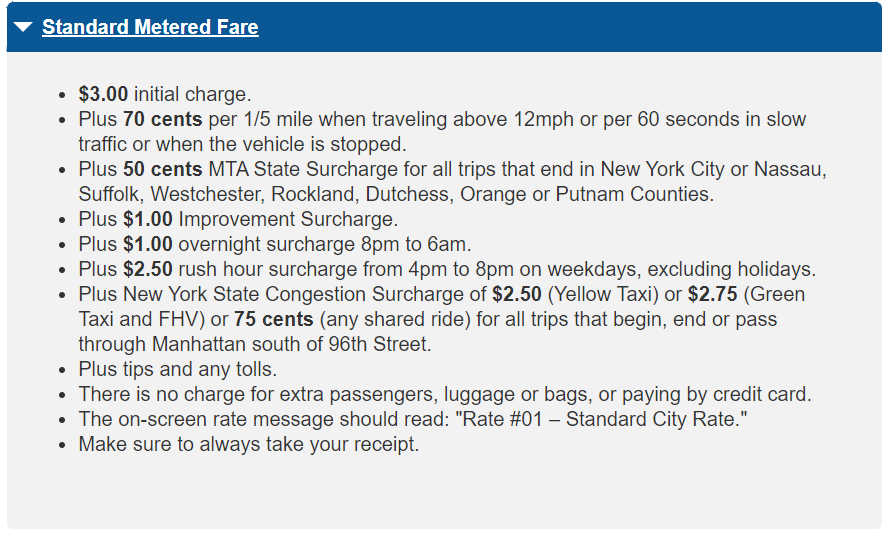

In [ ]:
mediaEarnings = spark.sql("""
SELECT vendorId, avg(earnings)
From Corridas_Com_Ganhos_Filtrada
Where earnings between 3 and 1777
group by vendorId
order by vendorId
""")

media_earnings_por_vendor_id = mediaEarnings.collect()

In [ ]:
for media in media_earnings_por_vendor_id:
  print(media)

In [ ]:
corridas_com_ganhos_ajustados_pela_media = spark.sql(f"""
SELECT
    VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, payment_type,
    CASE
        WHEN (earnings < 3 or earnings > 1777) and (vendorId = 1) THEN {media_earnings_por_vendor_id[0][1]}
        WHEN (earnings < 3 or earnings > 1777) and (vendorId = 2) THEN {media_earnings_por_vendor_id[1][1]}
        WHEN (earnings < 3 or earnings > 1777) and (vendorId = 5) THEN {media_earnings_por_vendor_id[2][1]}
        WHEN (earnings < 3 or earnings > 1777) and (vendorId = 6) THEN {media_earnings_por_vendor_id[3][1]}
        ELSE earnings
    END as earnings
FROM Corridas_Com_Ganhos_Filtrada
""")
corridas_com_ganhos_ajustados_pela_media.createOrReplaceTempView('Corridas_Com_Ganhos_Ajustados_Pela_Media')

Agora possuímos o dataset com os ganhos ajustados pela média de cada VendorID. Assim podemos prosseguir com a limpeza das outras colunas

### Distância percorrida
Para responder a análise 2, precisamos inputar valores nas linhas onde trip_distance é igual a zero. Observando na célula abaixo, 483129 corridas não possuem registro da distancia percorrida.

Para contornar esse problema, iremos inputar a média da distancia percorrida de cada VendorID nas linhas onde trip_distance for igual a 0

In [ ]:
spark.sql("""
select count(*) as quantidade_corridas_sem_distancia from Corridas_Com_Ganhos_Ajustados_Pela_Media where trip_distance = 0
""").show()

In [ ]:
spark.sql("""
select * from Corridas_Com_Ganhos_Ajustados_Pela_Media where payment_type <> 0 order by trip_distance desc
""").show()

In [ ]:
spark.sql("select count(*) as quantidade_de_corridas_grande_demais from Corridas_Com_Ganhos_Ajustados_Pela_Media where trip_distance > 360").show()

Definimos que as corridas que devem ser ajustadas são as menores de 0.05 milhas de distancia e as maiores do que 360 milhas. Esse limite superior foi definido assim pois é a distancia percorrida da corrida que adotamos para fazer o corte na limpeza dos ganhos, cujo ganho foi 1777 doláres. Iremos imputar a mediana dos valores dentro do intervalo que consideramos plausível.

In [ ]:
mediantrip_distance = spark.sql("""
SELECT VendorID, mean(trip_distance)
FROM Corridas_Com_Ganhos_Ajustados_Pela_Media
where trip_distance > 0.05 and trip_distance < 360
group by VendorID
order by VendorId
""")
medianas = mediantrip_distance.collect()

In [ ]:
medianas

In [ ]:
medianaVendor1 = medianas[0][1]
medianaVendor2 = medianas[1][1]
medianaVendor5 = medianas[2][1]
medianaVendor6 = medianas[3][1]

In [ ]:
corridas_com_trip_distance_ajustado = spark.sql(f"""
SELECT
    VendorID, tpep_pickup_datetime, tpep_dropoff_datetime,
    CASE
        WHEN (trip_distance <= 0.05) and (trip_distance < 360) and (vendorId = 6)
            THEN {medianaVendor6}
        WHEN (trip_distance <= 0.05) and (trip_distance < 360) and (vendorId = 5)
            THEN {medianaVendor5}
        WHEN (trip_distance <= 0.05) and (trip_distance < 360) and (vendorId = 1)
            THEN {medianaVendor1}
        WHEN (trip_distance <= 0.05) and (trip_distance < 360) and (vendorId = 2)
            THEN {medianaVendor2}
        ELSE trip_distance
    END as trip_distance,
    payment_type, earnings
FROM Corridas_Com_Ganhos_Ajustados_Pela_Media
""")
corridas_com_trip_distance_ajustado.createOrReplaceTempView('Corridas_Com_Trip_Distance_Ajustado')

Agora que já acertamos os valores de trip_distance e earnings para as corridas que não são no_charge e não foram canceladas, podemos juntar essa parte das corridas com a outra parte que havia sido separada.

In [ ]:
corridas_corrigidas = spark.sql("""
  select VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,payment_type, earnings from Corridas_Com_Trip_Distance_Ajustado
  union all

  select VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,payment_type, earnings from Corridas_Canceladas_E_Sem_Cobrancas
""")
corridas_corrigidas.createOrReplaceTempView("Corridas_Corrigidas")

In [ ]:
corridas_corrigidas = spark.table("Corridas_Corrigidas")
corridas_corrigidas.write.mode("overwrite").parquet("Corridas_Corrigidas")

In [ ]:
corridas_corrigidas = spark.read.parquet('Corridas_Corrigidas')
corridas_corrigidas.createOrReplaceTempView('Corridas_Corrigidas')

### Datas de início e fim da corrida
Percebemos que algumas datas de *tpep_pickup_datetime* e *tpep_dropoff_datetime* estavam fora do intevalo do ano de 2022. Para tratar isso aplicamos a seguinte regra:

*  Corridas que ambas as datas são fora de 2022, tem o ano ajustado para 2022, mantendo dia/mês e hora.
*  Corridas que somente uma das datas está fora de 2022, essa data será ajustada para estar igual ao seu par, preservando somente sua hora. Ou seja, ficaria no mesmo dia/mês do par que se encontra no ano de 2022.

In [ ]:
corridas_com_datas_corrigidas = spark.sql("""
select VendorID, pickup_datetime as tpep_pickup_datetime,
       dropoff_datetime as tpep_dropoff_datetime, trip_distance, payment_type, earnings
from (
    SELECT *,
    CASE
        WHEN (TO_DATE(tpep_pickup_datetime, 'yyyy-MM-dd HH:mm:ss') < '2021-12-30'
        AND TO_DATE(tpep_dropoff_datetime, 'yyyy-MM-dd HH:mm:ss') < '2021-12-30')
          THEN TO_TIMESTAMP(CONCAT('2022-', SUBSTRING(tpep_pickup_datetime, 6, 15)), 'yyyy-MM-dd HH:mm:ss')
        WHEN (TO_DATE(tpep_pickup_datetime, 'yyyy-MM-dd HH:mm:ss') < '2021-12-30'
        AND TO_DATE(tpep_dropoff_datetime, 'yyyy-MM-dd HH:mm:ss') >= '2021-12-30')
          THEN TO_TIMESTAMP(CONCAT('2022-', SUBSTRING(tpep_dropoff_datetime, 6, 15)), 'yyyy-MM-dd HH:mm:ss')
        ELSE TO_TIMESTAMP(tpep_pickup_datetime, 'yyyy-MM-dd HH:mm:ss')
    END AS pickup_datetime,
    CASE
        WHEN (TO_DATE(tpep_pickup_datetime, 'yyyy-MM-dd HH:mm:ss') < '2021-12-30'
        AND TO_DATE(tpep_dropoff_datetime, 'yyyy-MM-dd HH:mm:ss') < '2021-12-30')
          THEN TO_TIMESTAMP(CONCAT('2022-', SUBSTRING(tpep_dropoff_datetime, 6, 15)), 'yyyy-MM-dd HH:mm:ss')
        WHEN (TO_DATE(tpep_pickup_datetime, 'yyyy-MM-dd HH:mm:ss') >= '2021-12-30'
        AND TO_DATE(tpep_dropoff_datetime, 'yyyy-MM-dd HH:mm:ss') < '2021-12-30')
          THEN TO_TIMESTAMP(CONCAT('2022-', SUBSTRING(tpep_pickup_datetime, 6, 15)), 'yyyy-MM-dd HH:mm:ss')
        ELSE TO_TIMESTAMP(tpep_dropoff_datetime, 'yyyy-MM-dd HH:mm:ss')
    END AS dropoff_datetime
    FROM Corridas_Corrigidas
)
""")
corridas_com_datas_corrigidas.createOrReplaceTempView('Corridas_Datas_Corrigidas')

In [ ]:
corridas_com_datas_corrigidas = spark.sql("""
SELECT VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, payment_type, earnings
FROM Corridas_Datas_Corrigidas
WHERE YEAR(TO_DATE(tpep_dropoff_datetime, 'yyyy-MM-dd HH:mm:ss')) = 2022
""")
corridas_com_datas_corrigidas.createOrReplaceTempView('Corridas_Datas_Corrigidas')

### Tratando o Payment_type = 0
Precisamos classificar o payment_type 0 de alguma maneira dentre as categorias, visto que ele não se encontra no dicionário do dataset. Para isso, vamos analisar as frequências das corridas de cada payment_type que são diferentes de 0 por VendorID e fazer a inputação do payment_type onde ele é 0 de maneira que não afete a distribuição original.

In [ ]:
total_payment = spark.sql('select count(*) from Corridas_Datas_Corrigidas where payment_type <> 0').collect()[0][0]

frequencias = spark.sql(f"""
SELECT payment_type, COUNT(*) AS QTD, (COUNT(*) * 100.0 / {total_payment}) Frequencia
FROM Corridas_Datas_Corrigidas
where payment_type <> 0
group by payment_type
order by payment_type
""").collect()

In [ ]:
frequencia1 = frequencias[0][2]
frequencia2 = frequencias[1][2]
frequencia3 = frequencias[2][2]
frequencia4 = frequencias[3][2]
frequencia5 = frequencias[4][2]
frequencia6 = frequencias[5][2]

In [ ]:
contagem_zeros = spark.sql("""
SELECT count(*)
FROM Corridas_Datas_Corrigidas
where payment_type = 0

""").collect()[0][0]

In [ ]:
linhas1 = round(frequencia1*contagem_zeros/100)
linhas2 = round(frequencia2*contagem_zeros/100)
linhas3 = round(frequencia3*contagem_zeros/100)
linhas4 = round(frequencia4*contagem_zeros/100)
linhas5 = round(frequencia5*contagem_zeros/100)
linhas6 = round(frequencia6*contagem_zeros/100)
total = linhas1+linhas2+linhas3+linhas4+linhas5+linhas6

print(linhas1, linhas2, linhas3, linhas4, linhas5, linhas6)

In [ ]:
lista_linhas = [linhas1, linhas2, linhas3, linhas4, linhas5, linhas6]

In [ ]:
spark.sql("""
SELECT VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, payment_type, earnings
FROM Corridas_Datas_Corrigidas
where payment_type <> 0
""").createOrReplaceTempView("Corridas_Datas_Corrigidas_teste")

In [ ]:
zeros = spark.sql("""
SELECT VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, payment_type, earnings
FROM Corridas_Datas_Corrigidas
where payment_type = 0
""")

In [ ]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

window_spec = Window.orderBy("tpep_pickup_datetime")
df_with_rownum = zeros.withColumn("ROW_NUMBER", row_number().over(window_spec))

In [ ]:
df_with_rownum.createOrReplaceTempView("zeros")

In [ ]:
spark.sql(f"""
SELECT VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance,
CASE
  WHEN PAYMENT_TYPE = 0 AND ROW_NUMBER BETWEEN 0 AND {linhas1} THEN 1
  WHEN PAYMENT_TYPE = 0 AND ROW_NUMBER BETWEEN {linhas1+1} AND {(linhas1+1)+linhas2} THEN 2
  WHEN PAYMENT_TYPE = 0 AND ROW_NUMBER BETWEEN  {((linhas1+1)+linhas2)+1} AND {(((linhas1+1)+linhas2)+1)+linhas3} THEN 3
  WHEN PAYMENT_TYPE = 0 AND ROW_NUMBER BETWEEN {((((linhas1+1)+linhas2)+1)+linhas3)+1} AND {(((((linhas1+1)+linhas2)+1)+linhas3)+1)+linhas4} THEN 4
  WHEN PAYMENT_TYPE = 0 AND ROW_NUMBER BETWEEN {((((((linhas1+1)+linhas2)+1)+linhas3)+1)+linhas4)+1} AND {(((((((linhas1+1)+linhas2)+1)+linhas3)+1)+linhas4)+1)+linhas5} THEN 5
  WHEN PAYMENT_TYPE = 0 AND ROW_NUMBER BETWEEN {((((((((linhas1+1)+linhas2)+1)+linhas3)+1)+linhas4)+1)+linhas5)+1} AND {(((((((((linhas1+1)+linhas2)+1)+linhas3)+1)+linhas4)+1)+linhas5)+1)+linhas6} THEN 6
  ELSE PAYMENT_TYPE
  END payment_type, earnings
FROM zeros
where payment_type = 0

""").createOrReplaceTempView("zeros_trocados")

In [ ]:
spark.sql("""
SELECT VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, payment_type, earnings
FROM zeros_trocados

UNION ALL

SELECT VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, payment_type, earnings
FROM Corridas_Datas_Corrigidas_teste

""").createOrReplaceTempView("Corrida_datas_e_zeros_corrigidas")

In [ ]:
total_payment = spark.sql('select count(*) from Corrida_datas_e_zeros_corrigidas').collect()[0][0]

frequencias_novo = spark.sql(f"""
with  as (
    select count(*) from Corrida_datas_e_zeros_corrigidas
)
SELECT payment_type, COUNT(*) AS QTD, (COUNT(*) * 100.0 / {total_payment}) Frequencia
FROM Corrida_datas_e_zeros_corrigidas

group by payment_type
order by payment_type
""").collect()

In [ ]:
from pyspark.sql import Row

data = [
    Row(Payment_Type=antigo[0], Quantidade_antes=antigo[1], Frequencia_antes=antigo[2],
        Quantidade_apos_limpeza=novo[1], Frequencia_apos_limpeza=novo[2])
    for antigo, novo in zip(frequencias, frequencias_novo)
]


spark.createDataFrame(data).show(truncate=False)



Como é possível perceber, as quantidades de cada payment_type foi ligeiramente aumentada e a frequência se manteve quase que inalterada, sendo alterada somente em casas decimais muito precisas, devido ao arredondamento da contagem de linhas.

In [ ]:
spark.sql("""
SELECT *
FROM Corrida_datas_e_zeros_corrigidas

""").createOrReplaceTempView("Fato_Corridas")

In [ ]:
fato_corridas = spark.table("Fato_Corridas")
fato_corridas.write.mode("overwrite").parquet("Fato_Corridas")

In [ ]:
fato_corridas = spark.read.parquet('Fato_Corridas')
fato_corridas.createOrReplaceTempView('Fato_Corridas')

Finalmente temos nosso dataset limpo em um PARQUET chamado Fato_Corridas, que será nossa tabela fato utilizada em nossas análises. Essa tabela fato tem os seguintes atributos:

- VendorID
- tpep_pickup_datetime
- tpep_dropoff_datetime
- trip_distance
- payment_type
- earnings

## 3: Análise

### Pergunta 1: Qual o ganho médio por milha por mês por cada taxista durante todo o ano de 2022?



In [ ]:
spark.sql("""
SELECT
    COALESCE(CAST(VendorID AS STRING), 'TOTAL GERAL') AS VendorID,
    COALESCE(YEAR(tpep_dropoff_datetime), 'TOTAL ANUAL') AS ANO_ID,
    COALESCE(date_format(tpep_dropoff_datetime, "MM"), 'TOTAL MENSAL') AS MES_ID,
    ROUND(SUM(EARNINGS)/SUM(TRIP_DISTANCE), 2) AS GANHO_MEDIO_MES_MILHA
FROM
    Fato_Corridas
GROUP BY
    ROLLUP(VendorID, YEAR(tpep_dropoff_datetime), date_format(tpep_dropoff_datetime, "MM"))
ORDER BY
    VendorID, ANO_ID, MES_ID
""").show(100)

### Pergunta 2: Qual a taxa de corrida canceladas por mês para os taxistas que possuem o ganho médio por milha superior a média geral para o ano de 2022? Para obtermos essa resposta temos que:

In [ ]:
media_geral_ganho_por_milha = spark.sql("""
  SELECT SUM(earnings)/SUM(trip_distance) as Media_Geral
  FROM Fato_Corridas
""").collect()[0][0]
media_geral_ganho_por_milha

In [ ]:
spark.sql(f"""
SELECT
    A.VendorID,
    COALESCE(ROUND((C.Corridas_Canceladas)*100/B.Corridas_Totais,2),0) as Taxa_Cancelamento
FROM
(
    SELECT
        VendorID,
        SUM(earnings) / SUM(trip_distance) AS Media_Geral
    FROM
        Fato_Corridas
    GROUP BY
        VendorID
    HAVING
        SUM(earnings) / SUM(trip_distance) > {media_geral_ganho_por_milha}
) AS A
 JOIN
(
    SELECT
        VendorID,
        COUNT(*) AS Corridas_Totais
    FROM
        Fato_Corridas
    GROUP BY
        VendorID
) AS B
ON
    A.VendorID = B.VendorID
left JOIN
(
    SELECT
        VendorID,
        COUNT(*) AS Corridas_Canceladas
    FROM
        Fato_Corridas
    WHERE
        payment_type = 6
    GROUP BY
        VendorID
) AS C
ON
    B.VendorID = C.VendorID
order by taxa_cancelamento desc
""").show()

### Pergunta 3: Qual o ganho médio para os top-10 taxistas que mais rodaram por mês durante o ano de 2022?
Dessa análise entendemos que precisamos descobrir: Qual o ganho médio para os top-10 taxistas que mais rodaram por mês durante o ano de 2022?

In [ ]:
spark.sql("""
SELECT
A.VendorID,
B.Ganho_Medio_Mensal,
A.distancia_percorrida

FROM(
SELECT VendorID, distancia_percorrida
from(
SELECT VendorID, SUM(trip_distance) distancia_percorrida
FROM Fato_Corridas
GROUP BY VendorID
)
order by distancia_percorrida desc
LIMIT 10)
AS A
JOIN
(
SELECT VendorID, ROUND(SUM(earnings)/12,2) as Ganho_Medio_Mensal
FROM Fato_Corridas
GROUP BY VendorID
)
as B
ON A.VendorID = B.VendorID
order by A.distancia_percorrida desc
""").show()

### Suponha que incida uma taxa de 2% sobre cartão de crédito. Refaça as três análises anteriores.

#### Pergunta 1.2

Para responder as perguntas considerando a taxa de 2% sobre corridas no cartão de crédito. Iremos repetir a mesma consulta, porém de uma view diferente. View essa que ajustamos o ganho de cada corrida de payment_type = 1 (cartão de crédito) como sendo 98% do original.

In [ ]:
spark.sql("""
SELECT VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, payment_type, earnings_com_taxa as earnings
FROM
(SELECT *,
CASE
  WHEN (payment_type = 1) THEN earnings*0.98
  ELSE earnings
  END as earnings_com_taxa
FROM Fato_Corridas)
""").createOrReplaceTempView("Corridas_Com_Taxa")

In [ ]:
spark.sql("""
SELECT
    COALESCE(CAST(VendorID AS STRING), 'TOTAL GERAL') AS VendorID,
    COALESCE(YEAR(tpep_dropoff_datetime), 'TOTAL ANUAL') AS ANO_ID,
    COALESCE(date_format(tpep_dropoff_datetime, "MM"), 'TOTAL MENSAL') AS MES_ID,
    ROUND(SUM(EARNINGS)/SUM(TRIP_DISTANCE), 2) AS GANHO_MEDIO_MES_MILHA
FROM
    Corridas_Com_Taxa
GROUP BY
    ROLLUP(VendorID, YEAR(tpep_dropoff_datetime), date_format(tpep_dropoff_datetime, "MM"))
ORDER BY
    VendorID, ANO_ID, MES_ID
""").show(100)


#### Pergunta 2.2:


In [ ]:
media_milha_geral_com_taxa = spark.sql("""
  SELECT SUM(earnings)/SUM(trip_distance) as Media_Geral
  FROM Corridas_Com_Taxa
""").collect()[0][0]
media_milha_geral_com_taxa

In [ ]:
spark.sql(f"""
SELECT
    A.VendorID,
    COALESCE(ROUND((C.Corridas_Canceladas)*100/B.Corridas_Totais,2),0) as Taxa_Cancelamento
FROM
(
    SELECT
        VendorID,
        SUM(earnings) / SUM(trip_distance) AS Media_Geral
    FROM
        Corridas_Com_Taxa
    GROUP BY
        VendorID
    HAVING
        SUM(earnings) / SUM(trip_distance) > {media_milha_geral_com_taxa}
) AS A
 JOIN
(
    SELECT
        VendorID,
        COUNT(*) AS Corridas_Totais
    FROM
        Corridas_Com_Taxa
    GROUP BY
        VendorID
) AS B
ON
    A.VendorID = B.VendorID
left JOIN
(
    SELECT
        VendorID,
        COUNT(*) AS Corridas_Canceladas
    FROM
        Corridas_Com_Taxa
    WHERE
        payment_type = 6
    GROUP BY
        VendorID
) AS C
ON
    B.VendorID = C.VendorID
order by taxa_cancelamento desc
""").show()

#### Pergunta 3.2

In [ ]:
spark.sql("""
SELECT
A.VendorID,
B.Ganho_Medio_Mensal
 FROM(
SELECT VendorID, SUM(trip_distance)
FROM Corridas_Com_Taxa
GROUP BY VendorID
ORDER BY sum(trip_distance) desc
LIMIT 10)
AS A
JOIN
(
SELECT VendorID, ROUND(SUM(earnings)/12,2) as Ganho_Medio_Mensal
FROM Corridas_Com_Taxa
GROUP BY VendorID
)
as B
ON A.VendorID = B.VendorID
ORDER BY Ganho_Medio_Mensal desc
""").show()